In [1]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
anyio                        4.6.2
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        24.2.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.3
bleach                       6.2.0
Brotli                       1.0.9
cachetools                   5.5.0
certifi                      2024.8.30
cffi                         1.17.1
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.0
executing                    0.8.3
f

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [4]:
food_classes = ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 
                'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']

train_dir = 'foods_data/train'
test_dir = 'foods_data/test'

img_height = 32
img_width = 32
batch_size = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 9900 files belonging to 11 classes.
Found 1100 files belonging to 11 classes.


In [5]:
# Normalize datasets
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Apply data augmentation to the training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

# Prefetch data for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
x_train = []
y_train = []
for images, labels in train_dataset:
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

x_test = []
y_test = []
for images, labels in test_dataset:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

Example training images and their labels: [4, 7, 3, 4, 10, 1, 6, 2, 1, 4]
Corresponding classes for the labels: ['fried_rice', 'ice_cream', 'french_fries', 'fried_rice', 'sushi', 'cheesecake', 'hot_dog', 'chicken_curry', 'cheesecake', 'fried_rice']


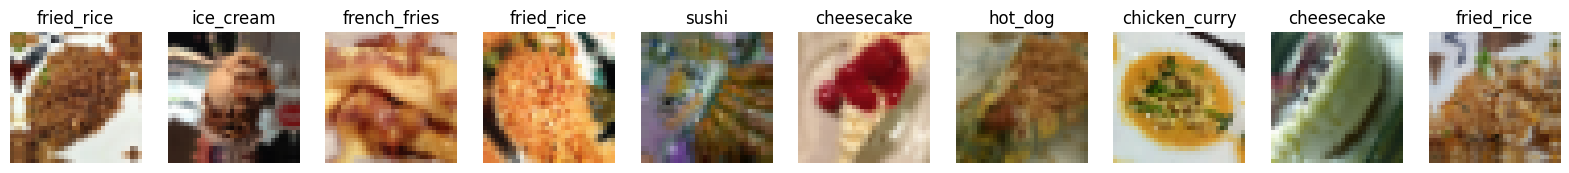

In [7]:
# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
num_classes = len(food_classes)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('Example training images and their labels: ' + str([np.argmax(y) for y in y_train[:10]]))
print('Corresponding classes for the labels: ' + str([food_classes[np.argmax(y)] for y in y_train[:10]]))

fig, axarr = plt.subplots(1, 10)
fig.set_size_inches(20, 6)

for i in range(10):
    image = (x_train[i] * 255).astype("uint8")  
    axarr[i].imshow(image)
    axarr[i].axis('off')
    axarr[i].set_title(food_classes[np.argmax(y_train[i])])

plt.show()

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9900, 32, 32, 3), (9900, 11), (1100, 32, 32, 3), (1100, 11))

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [48]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(11, activation='softmax')
])

In [49]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1152)              0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [50]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
history = model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
310/310 [==============================] - 6s 16ms/step - loss: 2.3114 - accuracy: 0.1583 - val_loss: 2.2091 - val_accuracy: 0.2155
Epoch 2/15
310/310 [==============================] - 5s 17ms/step - loss: 2.2050 - accuracy: 0.2216 - val_loss: 2.2082 - val_accuracy: 0.2082
Epoch 3/15
310/310 [==============================] - 5s 15ms/step - loss: 2.1471 - accuracy: 0.2476 - val_loss: 2.1332 - val_accuracy: 0.2473
Epoch 4/15
310/310 [==============================] - 5s 15ms/step - loss: 2.0984 - accuracy: 0.2682 - val_loss: 2.0675 - val_accuracy: 0.2945
Epoch 5/15
310/310 [==============================] - 5s 15ms/step - loss: 2.0474 - accuracy: 0.2904 - val_loss: 2.0690 - val_accuracy: 0.2891
Epoch 6/15
310/310 [==============================] - 4s 14ms/step - loss: 1.9851 - accuracy: 0.3074 - val_loss: 2.0695 - val_accuracy: 0.2955
Epoch 7/15
310/310 [==============================] - 5s 15ms/step - loss: 1.9440 - accuracy: 0.3298 - val_loss: 2.0258 - val_accuracy: 0.3145

In [52]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

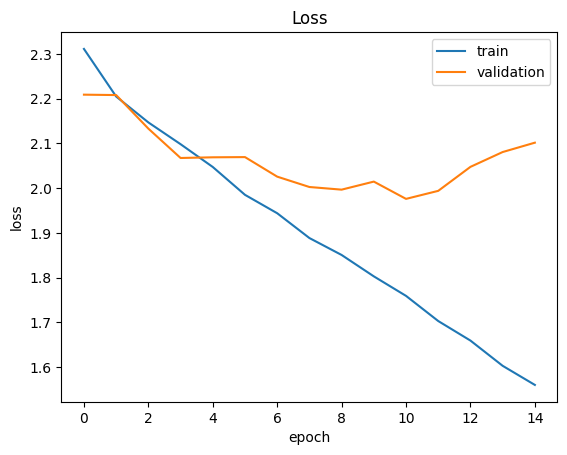

In [53]:
plotLosses(history)

In [54]:
def plotAccuracy(history):  
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

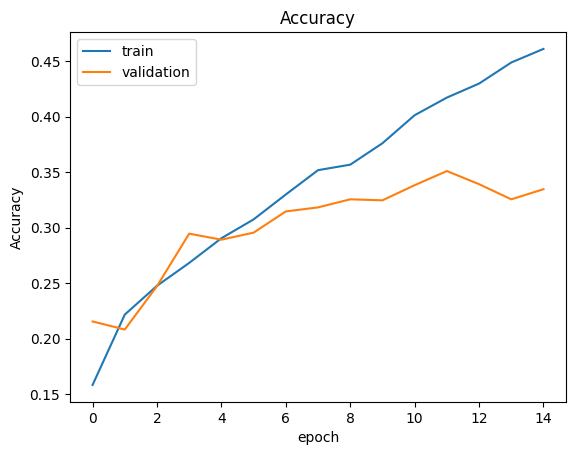

In [55]:
plotAccuracy(history)

In [56]:
from keras.models import load_model
model.save(os.path.join('models','FoodClassifier.h5'))

In [57]:
model = tf.keras.models.load_model('models\FoodClassifier.h5')

In [58]:
x_test_sample = np.expand_dims(x_test[20], axis=0)
predictions = model.predict(x_test_sample)

1/1 [==============================] - 0s 142ms/step


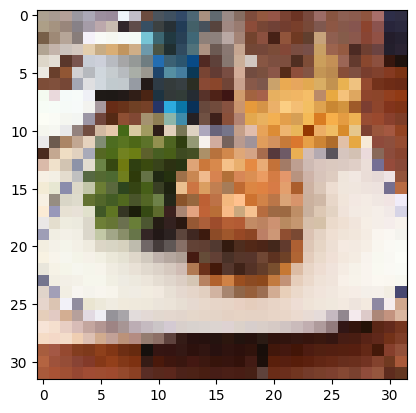

In [59]:
plt.imshow(x_test[20])

In [60]:
predicted_class_index = np.argmax(predictions)
predicted_class_name = food_classes[predicted_class_index]

print(f"The predicted class is: {predicted_class_name}")

The predicted class is: sushi
